# Conditional Variational Autoencoders for Human Face Generation

Firstly, we will investigate the improvement in reconstruction quality gained by allowing the VAE to view the ground truth gender, ethnicity and age labels. This is a conditional variational autoencoder.

TODO:
- Refactor the decoder to use Gaussian over each pixel rather than explicit point estimate.

In [1]:
!pip install pyarrow


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfpl = tfp.layers

## Dataset Preprocessing

In [3]:
data = pd.read_parquet("data.parquet")[['pixels','age','gender','ethnicity']]

# parse pixels datatype, resize and rescale
def preprocess_pixel_data(pixel_string: str) -> np.ndarray:
    return np.squeeze(np.array(pixel_string.split(' '), dtype="float32").reshape(48, 48, 1)/255., axis=-1)

data.pixels = data.pixels.apply(preprocess_pixel_data)

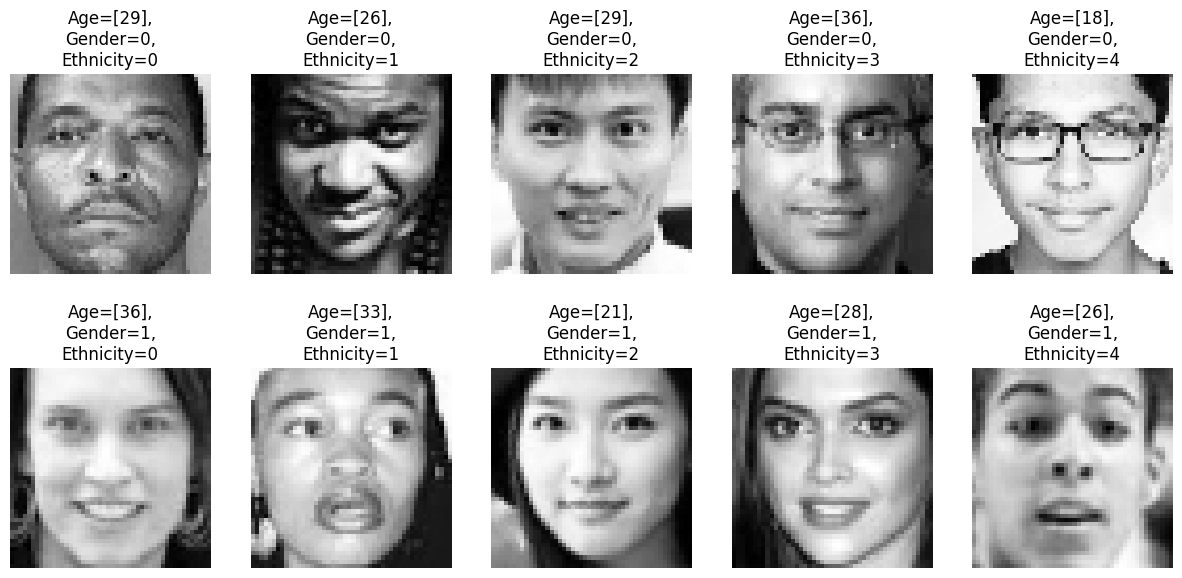

In [4]:
# plot of one observation per gender-ethnicity class.
f, axs = plt.subplots(2, 5, figsize=(15,7), sharex=True, sharey=True)

for gender in sorted(data.gender.unique()):
    for ethnicity in sorted(data.ethnicity.unique()):
        person = data.query('age>16').query('age<45')\
                     .query(f'gender=={gender}')\
                     .query(f'ethnicity=={ethnicity}')\
                     .sample()
        axs[gender,ethnicity].imshow(person.pixels.values[0], cmap = 'Greys_r')
        axs[gender,ethnicity].set_title(f"Age={person.age.values},\nGender={gender},\nEthnicity={ethnicity}")
        axs[gender,ethnicity].axis('off')

plt.show()

In [5]:
# we one-hot encode the ethnicity class variable. 
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_features = one_hot_encoder.fit_transform(data.ethnicity.values.reshape(-1,1))

ethnicities = ['caucasian','black','east_asian','south_asian','latino']

data[ethnicities] = encoded_features
data = data.drop('ethnicity', axis=1)

### Creating the Tensorflow dataset objects

In [6]:
# firstly, splitting data 80/10/10 
train_data, test_data = train_test_split(data, test_size=0.2, random_state=2023)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=2023)


# arranging the data to be suitable for VAE model training 
def inputs_and_outputs(image,label):
    return (image,label), image

# function to convert a pandas DataFrame into a TensorFlow dataset
def df_to_tf_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe[['age', 'gender'] + ethnicities]
    images = np.stack(dataframe['pixels'].to_numpy())
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(inputs_and_outputs)
    ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

# converting from DataFrames to TensorFlow datasets
train_ds = df_to_tf_dataset(train_data)
val_ds = df_to_tf_dataset(val_data)
test_ds = df_to_tf_dataset(test_data)

In [7]:
def retrieve_ethnicity_label(encoded_label: np.ndarray):
    return ethnicities[one_hot_encoder.inverse_transform(encoded_label.numpy().reshape(1,-1))[0][0]]

def retrieve_gender_label(encoded_label: int):
    if encoded_label == 0:
        return "Male"
    elif encoded_label == 1:
        return "Female"

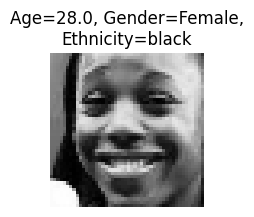

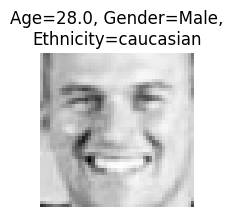

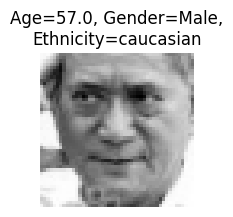

In [8]:
# quick check the datasets were processed properly
for (peek_images, peek_labels), _ in train_ds.take(3):
    peek_image = peek_images[0]
    peek_label = peek_labels[0]
    plt.figure(figsize=(2,2))
    plt.imshow(peek_image, cmap='Greys_r')
    plt.title(f"Age={peek_label[0]}, Gender={retrieve_gender_label(peek_label[1])},\n"+
              f"Ethnicity={retrieve_ethnicity_label(peek_label[2:])}")
    plt.axis('off')
    plt.show()

## Define a Custom KL Divergence Layer for Regularisation Scaling

In [9]:
class ScaledKLDivergenceLayer(tf.keras.layers.Layer):
    """ 
    Custom layer to compute the Kullback-Leibler divergence loss with a scaling factor.
    The true integral in the KLD is intractible, so we approximate with Monte carlo.
    """

    def __init__(self, 
                 prior, 
                 scale_factor=1.0, 
                 num_monte_carlo_samples=1, 
                 **kwargs):
        super(ScaledKLDivergenceLayer, self).__init__(**kwargs)
        self.prior = prior
        self.scale_factor = scale_factor
        self.test_points_fn = lambda d: d.sample(num_monte_carlo_samples)

    def call(self, inputs, training=None):
        return self.scale_factor * tfp.layers.KLDivergenceAddLoss(
            self.prior,
            use_exact_kl=False,
            test_points_fn = self.test_points_fn,
            test_points_reduce_axis = None)(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "prior": self.prior,
            "scale_factor": self.scale_factor,
            "use_exact_kl": self.use_exact_kl,
            "test_points_fn": self.test_points_fn
        })
        return config


## Standard VAE Model

In [10]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Reshape

# building the Model using the Keras functional API
np.random.seed(0)
tf.random.set_seed(0)

# define the number of latent variables
latent_dim = 128

prior = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim]))

In [11]:
# building the Encoder Model using the Keras functional API
image_input = Input(shape=(48,48,1), name='image')
label_input = Input(shape=(7,), name='label')

In [12]:
def build_encoder():
    # convolutional layers
    h = Conv2D(64, (2, 2), activation='relu', padding='same')(image_input)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(128, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(256, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(512, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(1024, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)

    # dense layers, now includes class and age labels
    h = Flatten()(h)

    # next we formulate the approximate posterior.
    # recall that TriL matrix represents Cholesky Decomposition of full Covariance Matrix
    h = Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim))(h)
    h = tfpl.MultivariateNormalTriL(latent_dim)(h)

    # KL Divergence term with a scaling factor to reduce regularisation
    z = ScaledKLDivergenceLayer(prior, scale_factor=0.001, num_monte_carlo_samples=5)(h)

    encoder = Model(inputs = [image_input, label_input], outputs = z, name='encoder')
    # label inputs provided but unused 
    
    return encoder

vae_encoder = build_encoder()

vae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 128)  32896       ['max_pooling2d[0][0]']          
                                                                                            

In [13]:
def build_decoder():
    z_input = Input(shape=(latent_dim,), name='z')
    
    # Dense layers
    h = Dense(latent_dim*20, activation='relu')(z_input)
    h = Dense(latent_dim*24, activation='relu')(h)
    h = Dense(latent_dim*28, activation='relu')(h)
    h = Dense(3*3*256, activation='relu')(h) 
    h = Reshape((48,48))(h)

    outputs = h

    decoder = Model(inputs=[z_input, label_input], outputs=outputs, name='decoder')

    return decoder

vae_decoder = build_decoder()
    
vae_decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z (InputLayer)                 [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 2560)         330240      ['z[0][0]']                      
                                                                                                  
 dense_2 (Dense)                (None, 3072)         7867392     ['dense_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 3584)         11013632    ['dense_2[0][0]']                
                                                                                            

In [14]:
vae = Model(inputs = vae_encoder.inputs, outputs = vae_decoder([vae_encoder.output, label_input]))

vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 128)  32896       ['max_pooling2d[0][0]']          
                                                                                              

In [16]:
# defining loss function and metrics

def reconstruction_loss(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred) 
    #recall that MSE is equivalent to logprob for Gaussian density

# peak signal to noise ratio
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [17]:
# model training

learning_rate = 0.001  # Set your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

vae.compile(optimizer=optimizer, loss=reconstruction_loss, metrics=[psnr_metric])

vae.fit(train_ds, 
        validation_data = val_ds, 
        epochs=100,
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2)])

Epoch 1/100
593/593 [==============================] - 17s 19ms/step - loss: 0.0973 - psnr_metric: 10.2156 - val_loss: 0.0634 - val_psnr_metric: 11.9917
Epoch 2/100
593/593 [==============================] - 7s 12ms/step - loss: 0.0393 - psnr_metric: 14.2005 - val_loss: 0.0276 - val_psnr_metric: 15.5881
Epoch 3/100
593/593 [==============================] - 8s 12ms/step - loss: 0.0261 - psnr_metric: 15.8475 - val_loss: 0.0252 - val_psnr_metric: 16.0209
Epoch 4/100
593/593 [==============================] - 7s 12ms/step - loss: 0.0246 - psnr_metric: 16.1122 - val_loss: 0.0236 - val_psnr_metric: 16.3043
Epoch 5/100
593/593 [==============================] - 7s 12ms/step - loss: 0.0236 - psnr_metric: 16.2898 - val_loss: 0.0235 - val_psnr_metric: 16.3180
Epoch 6/100
593/593 [==============================] - 8s 12ms/step - loss: 0.0225 - psnr_metric: 16.4889 - val_loss: 0.0207 - val_psnr_metric: 16.8750
Epoch 7/100
593/593 [==============================] - 8s 12ms/step - loss: 0.0194 - ps

## Conditional VAE Model

In [18]:
def build_cvae_encoder():
    # convolutional layers
    h = Conv2D(64, (2, 2), activation='relu', padding='same')(image_input)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(128, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(256, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(512, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)
    h = Conv2D(1024, (2, 2), activation='relu', padding='same')(h)
    h = MaxPooling2D((2, 2), padding='same')(h)

    # dense layers, now includes class and age labels
    h = Flatten()(h)
    h = Concatenate()([h, label_input])

    # next we formulate the approximate posterior.
    # recall that TriL matrix represents Cholesky Decomposition of full Covariance Matrix
    h = Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim))(h)
    h = tfpl.MultivariateNormalTriL(latent_dim)(h)

    # KL Divergence term with a scaling factor to reduce regularisation
    z = ScaledKLDivergenceLayer(prior, scale_factor=0.001, num_monte_carlo_samples=5)(h)

    encoder = Model(inputs = [image_input, label_input], outputs = z, name='encoder')
    
    return encoder

cvae_encoder = build_cvae_encoder()

cvae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 48, 48, 64)   320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 24, 24, 64)  0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 24, 24, 128)  32896       ['max_pooling2d_5[0][0]']        
                                                                                            

In [19]:
def build_cvae_decoder():
    z_input = Input(shape=(latent_dim,), name='z')

    # combine the latent vector and the label input
    h = Concatenate()([z_input, label_input])

    # Dense layers
    h = Dense(latent_dim*20, activation='relu')(h)
    h = Dense(latent_dim*24, activation='relu')(h)
    h = Dense(latent_dim*28, activation='relu')(h)
    h = Dense(3*3*256, activation='relu')(h) 
    h = Reshape((48,48))(h)

    outputs = h

    decoder = Model(inputs=[z_input, label_input], outputs=outputs, name='decoder')

    return decoder

cvae_decoder = build_cvae_decoder()
    
cvae_decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z (InputLayer)                 [(None, 128)]        0           []                               
                                                                                                  
 label (InputLayer)             [(None, 7)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 135)          0           ['z[0][0]',                      
                                                                  'label[0][0]']                  
                                                                                                  
 dense_6 (Dense)                (None, 2560)         348160      ['concatenate_1[0][0]']    

In [20]:
cvae = Model(inputs = cvae_encoder.inputs, outputs = cvae_decoder([cvae_encoder.output, label_input]))

cvae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 48, 48, 64)   320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 24, 24, 64)  0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 24, 24, 128)  32896       ['max_pooling2d_5[0][0]']        
                                                                                            

In [21]:
# model training

learning_rate = 0.001  # Set your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

cvae.compile(optimizer=optimizer, loss=reconstruction_loss, metrics=[psnr_metric])

cvae.fit(train_ds, 
         validation_data = val_ds, 
         epochs=100,
         callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2)])

Epoch 1/100
593/593 [==============================] - 18s 27ms/step - loss: 0.0737 - psnr_metric: 11.9332 - val_loss: 0.0469 - val_psnr_metric: 13.3101
Epoch 2/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0375 - psnr_metric: 14.2852 - val_loss: 0.0325 - val_psnr_metric: 14.8880
Epoch 3/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0286 - psnr_metric: 15.4596 - val_loss: 0.0273 - val_psnr_metric: 15.6374
Epoch 4/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0244 - psnr_metric: 16.1499 - val_loss: 0.0221 - val_psnr_metric: 16.5729
Epoch 5/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0213 - psnr_metric: 16.7385 - val_loss: 0.0200 - val_psnr_metric: 16.9971
Epoch 6/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0184 - psnr_metric: 17.3749 - val_loss: 0.0172 - val_psnr_metric: 17.6440
Epoch 7/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0166 - ps

In [33]:
# # Plot the losses if you want
# plt.plot(vae.history.history['loss'], label='VAE Training Loss')
# plt.plot(vae.history.history['val_loss'], label='VAE Validation Loss')
# plt.plot(cvae.history.history['loss'], label='CVAE Training Loss')
# plt.plot(cvae.history.history['val_loss'], label='CVAE Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Test set evaluation

1/1 [==============================] - 0s 37ms/step


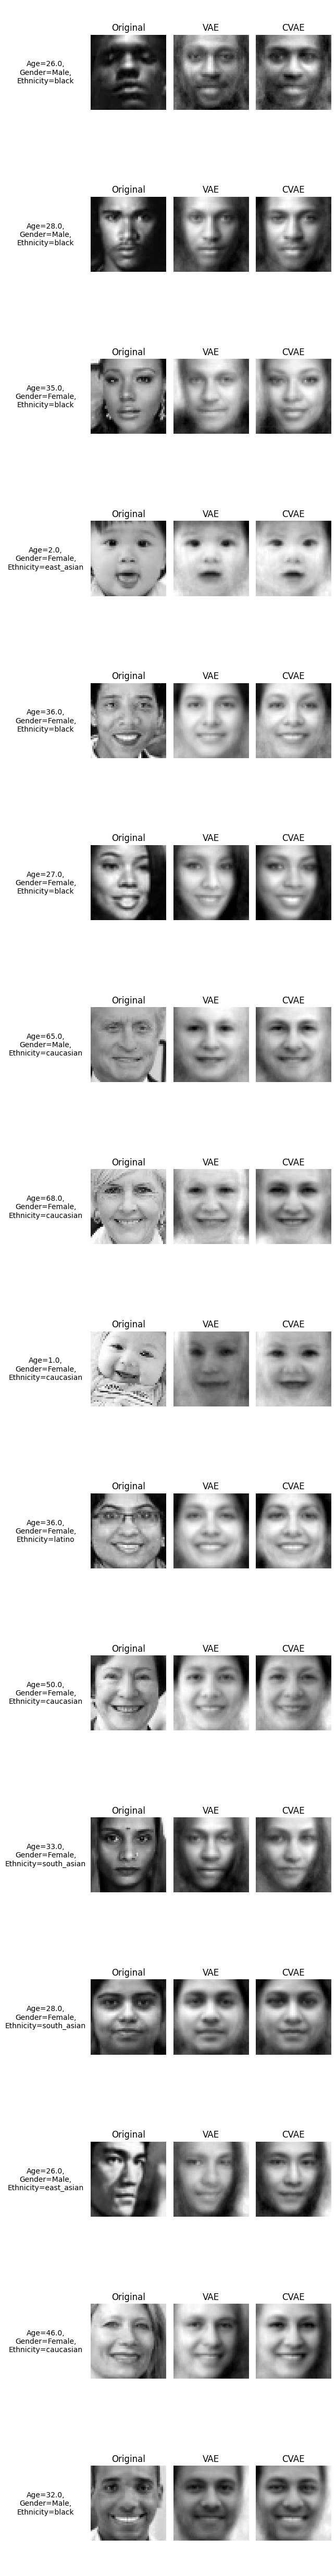

In [29]:
# Generate a few test data examples
num_examples = 16
test_samples = test_ds.take(num_examples)

# obtain the original images and their VAE reconstructions
original_images = []
original_labels = []
vae_reconstructed_images = []
cvae_reconstructed_images = []

for (image,label),_ in test_samples:
    original_images.append(image[0].numpy())  # Extract the first image from each batch
    original_labels.append(label[0])
    vae_reconstructed_image = vae.predict([image, label])[0]  # Generate reconstruction using cvae model
    vae_reconstructed_images.append(vae_reconstructed_image)
    cvae_reconstructed_image = cvae.predict([image, label])[0]  # Generate reconstruction using cvae model
    cvae_reconstructed_images.append(cvae_reconstructed_image)
    
# plot original images vs VAE reconstructions
fig, axes = plt.subplots(nrows=num_examples, ncols=4, 
                         figsize=(8, num_examples*4), 
                         gridspec_kw = {'wspace':0.1})

for i in range(num_examples):
    text_description = f"Age={original_labels[i][0]},\n"+\
                       f"Gender={retrieve_gender_label(original_labels[i][1])},\n"+\
                       f"Ethnicity={retrieve_ethnicity_label(original_labels[i][2:])}"    
    axes[i, 0].text(0.5, 0.5, text_description, fontsize=10, ha='center', va='center')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(original_images[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Original')

    axes[i, 2].imshow(vae_reconstructed_images[i], cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('VAE')

    axes[i, 3].imshow(cvae_reconstructed_images[i], cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 3].set_title('CVAE')

plt.tight_layout()
plt.show()